In this model I explore Natural Language Processing (NLP) with respect to sentiment analysis of tweets. The Kaggle Disaster Tweets dataset was used to build this model.

The first step in this project is to clean the data and preprocess it for training. The data provided includes keywords and location. This information was not relevant to the content of the tweet so was removed from the data to reduced noise in the model leaving the text only. Looking through the data it can be seen that lots of special characters and contractions are used in the tweets, this potentially may affect the accuracy of the model so were removed to standardize the text. Contractions were replaced with the full words they represent which was represented in a dictionary. Special characters were removed, and words put in lower case during the tokenization step.

The text was tokenized using the keras TextVectorization class. Words were split by whitespace and the output vectors were padded so all feature vectors were of the same length. Integer encoding was used for the word representation. the vectorization was fit to the training set to build the vocabulary for the tokenization.

Next the model was built. For this problem an recurrent neural network was used as they are well suited for NLP due to the preservation of the relative position of words.

First an Embedding Layer was used with an input size of vocabulary + 1 and an output dimension of 32. The output from the tokenization is a numerical representation of the vocabulary. In order to learn the relationship between words the tokenized words (numbers) can be mapped into a vector space where the model can learn relationships between words. The vector space should be large enough to avoid data loss from compressing the unique tokens to the vector representations, however too large a vector space can lead to overfitting the embedding parameters to the inputs. Additionally, a higher dimension embedding will significantly increase model complexity and the number of trainable parameters. Additionaly L2 regularization was applied to this layer, so no embedding vector parameter became too large which would have lead to overfitting in the model, L1 regularization can have the unattended effect of setting a parameter to zero which may affect the model's performance.

The second layer in the model is a bidirectional LSTM (long short-term memory). This RNN layer is relatively insensitive to gap length, and is suited for sequential data like text. The advantage of RNN is that it can carry forward information from previous time-steps (or words in the case of NLP) helping to preserve context. Other RNN structure suffer from loosing context with longer distances between relevant words, LSTM attempts to overcome this issue. LSTM have three main gates, a forget gate layer which decided what information to discard from the current cell state. The input gate decided which values in the cell state to update, and finally a activation function to decide what the new information should be. For this model a bidirectional implementation was selected as processing the text in both directions may help to understand the relationship between words better. dropout of 0.5 was chosen for the layer to help prevent overfitting to parameters.




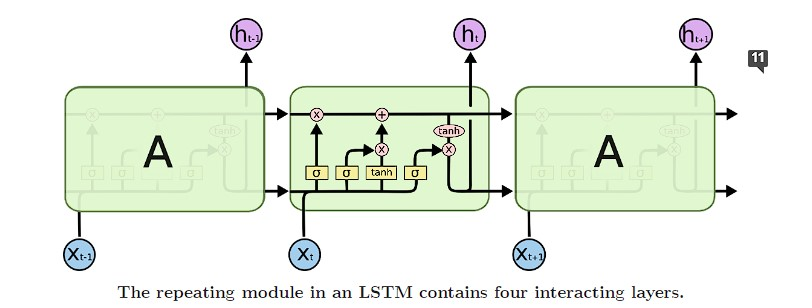

The final layer in the model is a fully connected (FC) output layer (Dense) of 1 cell with a sigmoid activation. This was selected as this is a binary classification problem, so the model output should be 1 or 0.

Adam was the selected optimization algorithim, and the loss was selected to be binary crossentropy. the model had a maxinium accuracy at the second epoch of 79.8%.

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [6]:
#Load Training Data
train_df = pd.read_csv("train.csv")
train_df.sample(frac=1)

,id,keyword,location,text,target
4046,5746,forest%20fires,Montana,The forest service now spends &gt;50% of its b...,1
5514,7868,quarantined,"Karolinska vÌ_gen 18, Solna",Officials say a quarantine is in place at a Bi...,1
1384,1995,bush%20fires,Wolmers Trust School for Boys,Drought fuels bush fires in Jamaica - http://t...,1
3894,5538,flattened,"Chorley, Lancashire, UK",Fylde Building set to be flattened: One of Pre...,0
7081,10142,upheaval,maryland,A Look at State Actions a Year after Ferguson...,1
...,...,...,...,...,...
4247,6034,hazardous,"British Columbia, Canada",Skinny Jeans are Hazardous for Your Health! #s...,1
4507,6405,hurricane,NaN,Cape Coral city leaders take part in mock hurr...,1
3516,5027,eyewitness,"Terlingua, Texas",#ClimateChange Eyewitness to Extreme Weather: ...,1
167,242,airplane%20accident,"San Francisco, CA",Statistically I'm at more of risk of getting k...,0


In [7]:
#load test data for kaggle
test_df = pd.read_csv("test.csv")
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [8]:
#select only the text data as a feature
X_test_run = test_df["text"]


In [9]:
#visualizing a non disaster tweet
train_df[train_df["target"] == 0]["text"].values[0]

"What's up man?"

In [10]:
# visualizing a disaster tweet
train_df[train_df["target"] == 1]["text"].values[10]

'Three people died from the heat wave so far'

In [11]:
#make X, and Y dataframs
X_train = train_df["text"]
y_train = train_df["target"]


In [12]:
#replace contractions in training and test sets
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

for i in range(len(X_train)):
  for word in contractions:
    X_train.iloc[i].replace(word, contractions[word])

In [13]:
for i in range(len(X_test_run)):
  for word in contractions:
    X_test_run.iloc[i].replace(word, contractions[word])

In [14]:
# check that contractions have been replaced
X_train[4]

'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '

In [15]:
#length of each text in dataset
max_length = X_train.str.len().max()
max_length

157

In [16]:
#this is to suffle data for training validation splits
X_train.reset_index(drop=True)

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [17]:
#define and fit tockenizer that also removes special symbols and lowercases text
int_vectorization = tf.keras.layers.TextVectorization(output_sequence_length=int(max_length))
int_vectorization.adapt(X_train)

In [18]:
#tokenized repersentation of sentence
print(int_vectorization(X_train[10]).numpy())

[591  56 627  20   2 281 466  31 625   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [19]:
int_vectorization(X_train[10]).shape

TensorShape([157])

In [20]:
#length of vocanulary
vocab = len(int_vectorization.get_vocabulary())
print("Vocabulary size: {}".format(vocab))

Vocabulary size: 22699


In [21]:
#apply tokenizer to training set
X_train = int_vectorization(X_train)

In [23]:
#apply tockenizer to test set
X_test_run = int_vectorization(X_test_run)

In [24]:
# build model embedding, LSTM and output layers
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab+1, 32, embeddings_regularizer=tf.keras.regularizers.L2(1e-4) ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout=0.5)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
#compile model with adam as optimizer and binary_crossentropy as the loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
#Train model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1)

215/215 [==============================] - 35s 139ms/step - loss: 0.6135 - accuracy: 0.6662 - val_loss: 0.5399 - val_accuracy: 0.7310
Epoch 2/20
215/215 [==============================] - 25s 116ms/step - loss: 0.4056 - accuracy: 0.8396 - val_loss: 0.4698 - val_accuracy: 0.7874
Epoch 3/20
215/215 [==============================] - 25s 115ms/step - loss: 0.2903 - accuracy: 0.9015 - val_loss: 0.4890 - val_accuracy: 0.7874
Epoch 4/20
215/215 [==============================] - 25s 115ms/step - loss: 0.2158 - accuracy: 0.9348 - val_loss: 0.5779 - val_accuracy: 0.7677
Epoch 5/20
215/215 [==============================] - 25s 116ms/step - loss: 0.1688 - accuracy: 0.9559 - val_loss: 0.5826 - val_accuracy: 0.7900
Epoch 6/20
215/215 [==============================] - 25s 116ms/step - loss: 0.1372 - accuracy: 0.9667 - val_loss: 0.6082 - val_accuracy: 0.7677
Epoch 7/20
215/215 [==============================] - 25s 117ms/step - loss: 0.1165 - accuracy: 0.9734 - val_loss: 0.6949 - val_accuracy: 0.7

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


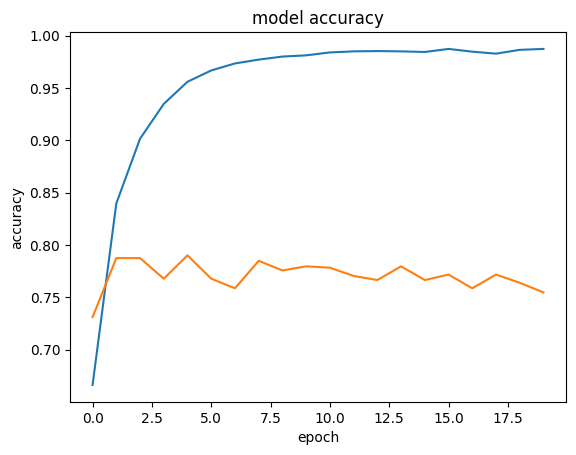

In [27]:
#visualize the training over epochs
import matplotlib.pyplot as plt

print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


In [36]:
#summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          726400    
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 732705 (2.80 MB)
Trainable params: 732705 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Make prdictions
results = model.predict(X_test_run)

102/102 [==============================] - 3s 21ms/step


In [30]:
results = pd.DataFrame(results)

In [31]:
results = results.round()
results = test_df.join(results)
results = results[["id",0]]
results = results.set_index("id")
results

,0
id,
0,0.0
2,0.0
3,1.0
9,1.0
11,1.0
...,...
10861,1.0
10865,1.0
10868,1.0


In [32]:
#exporting estimaes of the training data
results.to_csv("results.csv")